# Bayesian imputation for missing values in discrete covariates with HMC

Missing data is a very widespread problem in practical applications, both in covariates ('explanatory variables') and outcomes.
When performing bayesian inference with MCMC, imputing discrete missing values is not possible using Hamiltonian Monte Carlo techniques.
One way around this problem is to create a new model that enumerates the discrete variables and does inference over the new model, which, for a single discrete variable, is a mixture model. (see e.g. [Stan's user guide on Latent Discrete Parameters](https://mc-stan.org/docs/2_18/stan-users-guide/change-point-section.html))
Enumerating the discrete latent sites requires some manual math work that can get tedious for complex models.
Inference by automatic enumeration of discrete variables is implemented in numpyro and allows for a very convenient way of dealing with missing discrete data.


In [1]:
import numpyro
from jax import numpy as jnp, random, ops
from jax.scipy.special import expit
from numpyro import distributions as dist, sample
from numpyro.infer.mcmc import MCMC
from numpyro.infer.hmc import NUTS
from math import inf
from graphviz import Digraph

simkeys = random.split(random.PRNGKey(0), 10)
nsim    = 5000
mcmc_key = random.PRNGKey(1)

First we will simulate data with correlated binary covariates. The assumption is that we wish to estimate parameter for some parametric model without bias (e.g. for inferring a causal effect). For several different missing data patterns we will see how to impute the values to lead to unbiased models. 

The basic data structure is as follows. Z is a latent variable that gives rise to the marginal dependence between A and B, the observed covariates. We will consider different missing data mechanisms for variable A, where variable B and Y are fully observed. The effects of A and B on Y are the effects of interest.

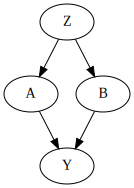

In [2]:
dot = Digraph()
dot.node('A')
dot.node('B')
dot.node('Z')
dot.node('Y')
dot.edges(['ZA', 'ZB', 'AY', 'BY'])
dot

In [3]:
b_A = 0.25
b_B = 0.25
s_Y = 0.25
Z = random.normal(simkeys[0], (nsim, ))
A = random.bernoulli(simkeys[1], expit(Z))
B = random.bernoulli(simkeys[2], expit(Z))
Y = A * b_A + B * b_B + s_Y * random.normal(simkeys[3], (nsim,))

## MAR conditional on outcome

According to Rubin's classic definitions there are 3 distinct of missing data mechanisms:

1. missing completely at random (MCAR)
2. missing at random, conditional on observed data (MAR)
3. missing not at random, even after conditioning on observed data (MNAR)

Missing data mechanisms 1. and 2. are 'easy' to handle as they depend on observed data only.
Mechanism 3. (MNAR) is trickier as it depends on data that is not observed, but may still be relevant to the outcome you are modeling (see below for a concrete example).

First we will generate missing values in A, conditional on the value of Y (thus it is a MAR mechanism).

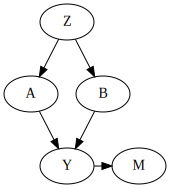

In [4]:
dot_mnar_y = Digraph()
with dot_mnar_y.subgraph() as s:
    s.attr(rank='same')
    s.node('Y')
    s.node('M')
dot_mnar_y.node('A')
dot_mnar_y.node('B')
dot_mnar_y.node('Z')
dot_mnar_y.node('M')
dot_mnar_y.edges(['YM', 'ZA', 'ZB', 'AY', 'BY'])
dot_mnar_y

This graph depicts the datagenerating mechanism, where Y is the only cause of missingness in A, denoted M. This means that the missingness in M is random, conditional on Y.

As an example consider this simplified scenario:

- A represents a history of heart illness
- B represents the age of a patient
- Y represents whether or not the patient will visit the general practitioner

A general practitioner wants to find out why patients that are assigned to her clinic will visit the clinic or not. She thinks that having a history of heart illness and age are potential causes of doctor visits. Data on patient ages are available through their registration forms, but information on prior heart illness may be availalbe only after they have visited the clinic. This makes the missingness in A (history of heart disease), dependent on the outcome (visiting the clinic).

In [5]:
A_isobs = random.bernoulli(simkeys[4], expit(3*(Y - Y.mean())))
Aobs = jnp.where(A_isobs, A, -1)
A_obsidx = jnp.where(A_isobs)

# generate complete case arrays
Acc = Aobs[A_obsidx]
Bcc = B[A_obsidx]
Ycc = Y[A_obsidx]

We will evaluate 2 approaches:

1. complete case analysis (which will lead to biased inferences)
2. with imputation (conditional on B)
    
Note that explicitly including Y in the imputation model for A is unneccesary.
The sampled imputations for A will condition on Y indirectly as the likelihood of Y is conditional on A.
So values of A that give high likelihood to Y will be sampled more often than other values.

In [6]:
def ccmodel(A, B, Y):
    ntotal = A.shape[0]
    # get parameters of outcome model
    b_A = sample('b_A', dist.Normal(0, 2.5))
    b_B = sample('b_B', dist.Normal(0, 2.5))
    s_Y = sample('s_Y', dist.HalfCauchy(2.5))
    
    with numpyro.plate('obs', ntotal):
        ### outcome model 
        eta_Y = b_A * A + b_B * B
        sample("obs_Y", dist.Normal(eta_Y, s_Y), obs=Y)

In [7]:
cckernel = NUTS(ccmodel)
ccmcmc   = MCMC(cckernel, num_warmup=250, num_samples=750)
ccmcmc.run(mcmc_key, Acc, Bcc, Ycc)
ccmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 348.50it/s, 3 steps of size 4.27e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.30      0.01      0.30      0.29      0.31    500.83      1.00
       b_B      0.28      0.01      0.28      0.27      0.29    546.34      1.00
       s_Y      0.25      0.00      0.25      0.24      0.25    559.55      1.00

Number of divergences: 0


In [8]:
def impmodel(A, B, Y):
    ntotal = A.shape[0]
    A_isobs = A >= 0

    # get parameters of imputation model
    mu_A = sample("mu_A", dist.Normal(0, 2.5))
    b_B_A = sample("b_B_A", dist.Normal(0, 2.5))    

    # get parameters of outcome model
    b_A = sample('b_A', dist.Normal(0, 2.5))
    b_B = sample('b_B', dist.Normal(0, 2.5))
    s_Y = sample('s_Y', dist.HalfCauchy(2.5))
    
    with numpyro.plate('obs', ntotal):
        ### imputation model
        # get linear predictor for missing values
        eta_A = mu_A + B * b_B_A

        # sample imputation values for A
        # mask out to not add log_prob to total likelihood right now
        Aimp = sample("A", dist.Bernoulli(logits=eta_A).mask(False)) 
        
        # 'manually' calculate the log_prob
        log_prob = dist.Bernoulli(logits=eta_A).log_prob(Aimp)
        
        # cancel out enumerated values that are not equal to observed values
        log_prob = jnp.where(A_isobs & (Aimp != A), -inf, log_prob) 
        
        # add to total likelihood for sampler
        numpyro.factor('A_obs', log_prob)
            
        ### outcome model 
        eta_Y = b_A * Aimp + b_B * B
        sample("obs_Y", dist.Normal(eta_Y, s_Y), obs=Y)


In [9]:
impkernel = NUTS(impmodel)
impmcmc   = MCMC(impkernel, num_warmup=250, num_samples=750)
impmcmc.run(mcmc_key, Aobs, B, Y)
impmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:05<00:00, 174.83it/s, 7 steps of size 4.41e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.25      0.01      0.25      0.24      0.27    447.79      1.01
       b_B      0.25      0.01      0.25      0.24      0.26    570.66      1.01
     b_B_A      0.74      0.08      0.74      0.60      0.86    316.36      1.00
      mu_A     -0.39      0.06     -0.39     -0.48     -0.29    290.86      1.00
       s_Y      0.25      0.00      0.25      0.25      0.25    527.97      1.00

Number of divergences: 0


As we can see, when data are missing conditionally on Y, imputation leads to consistent estimation of the parameter of interest (b_A and b_B).

## MNAR conditional on covariate

When data are missing conditional on unobserved data, things get more tricky.
Here we will generate missing values in A, conditional on the value of A itself (missing not at random (MNAR), but missing at random conditional on A).

As an example consider patients who have cancer:

- A represents weight loss
- B represents age
- Y represents overall survival time

Both A and B can be related to survival time in cancer patients. For patients who have extreme weight loss, it is more likely that this will be noted by the doctor and registered in the electronic health record. For patients with no weight loss or little weight loss, it may be that the doctor forgets to ask about it and therefore does not register it in the records.

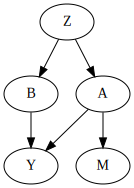

In [10]:
dot_mnar_x = Digraph()
with dot_mnar_y.subgraph() as s:
    s.attr(rank='same')
    s.node('A')
    s.node('M')
dot_mnar_x.node('B')
dot_mnar_x.node('Z')
dot_mnar_x.node('Y')
dot_mnar_x.edges(['AM', 'ZA', 'ZB', 'AY', 'BY'])
dot_mnar_x

In [11]:
A_isobs = random.bernoulli(simkeys[5], 0.9 - 0.8 * A)
Aobs = jnp.where(A_isobs, A, -1)
A_obsidx = jnp.where(A_isobs)

# generate complete case arrays
Acc = Aobs[A_obsidx]
Bcc = B[A_obsidx]
Ycc = Y[A_obsidx]

In [12]:
cckernel = NUTS(ccmodel)
ccmcmc   = MCMC(cckernel, num_warmup=250, num_samples=750)
ccmcmc.run(mcmc_key, Acc, Bcc, Ycc)
ccmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 342.07it/s, 3 steps of size 5.97e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.27      0.02      0.26      0.24      0.29    667.08      1.01
       b_B      0.25      0.01      0.25      0.24      0.26    811.49      1.00
       s_Y      0.25      0.00      0.25      0.24      0.25    547.51      1.00

Number of divergences: 0


In [13]:
impkernel = NUTS(impmodel)
impmcmc   = MCMC(impkernel, num_warmup=250, num_samples=750)
impmcmc.run(mcmc_key, Aobs, B, Y)
impmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:06<00:00, 166.36it/s, 7 steps of size 4.10e-01. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.34      0.01      0.34      0.32      0.35    576.15      1.00
       b_B      0.33      0.01      0.33      0.32      0.34    800.58      1.00
     b_B_A      0.32      0.12      0.32      0.12      0.51    342.21      1.01
      mu_A     -1.81      0.09     -1.81     -1.95     -1.67    288.57      1.00
       s_Y      0.26      0.00      0.26      0.25      0.26    820.20      1.00

Number of divergences: 0


Perhaps surprisingly, imputing missing values when the missingness mechanism depends on the variable itself will actually lead to bias, while complete case analysis is unbiased!
See e.g. [Bias and efficiency of multiple imputation compared with complete‐case analysis for missing covariate values](https://doi.org/10.1002/sim.3944).

However, complete case analysis may be undesirable as well. E.g. due to leading to lower precision in estimating the parameter from B to Y, or maybe when there is an expected difference interaction between the value of A and the parameter from A to Y. To deal with this situation, an explicit model for the reason of missingness (/observation) is required. We will add one below.

In [14]:
def impmissmodel(A, B, Y):
    ntotal = A.shape[0]
    A_isobs = A >= 0

    # get parameters of imputation model
    mu_A = sample("mu_A", dist.Normal(0, 2.5))
    b_B_A = sample("b_B_A", dist.Normal(0, 2.5))    

    # get parameters of outcome model
    b_A = sample('b_A', dist.Normal(0, 2.5))
    b_B = sample('b_B', dist.Normal(0, 2.5))
    s_Y = sample('s_Y', dist.HalfCauchy(2.5))
    
    # get parameter of model of missingness
    with numpyro.plate('obsmodel', 2):
        p_Aobs = sample('p_Aobs', dist.Beta(1,1))
    
    with numpyro.plate('obs', ntotal):
        ### imputation model
        # get linear predictor for missing values
        eta_A = mu_A + B * b_B_A

        # sample imputation values for A
        # mask out to not add log_prob to total likelihood right now
        Aimp = sample("A", dist.Bernoulli(logits=eta_A).mask(False)) 
        
        # 'manually' calculate the log_prob
        log_prob = dist.Bernoulli(logits=eta_A).log_prob(Aimp)
        
        # cancel out enumerated values that are not equal to observed values
        log_prob = jnp.where(A_isobs & (Aimp != A), -inf, log_prob) 
        
        # add to total likelihood for sampler
        numpyro.factor('obs_A', log_prob)
        
        ### outcome model 
        eta_Y = b_A * Aimp + b_B * B
        sample("obs_Y", dist.Normal(eta_Y, s_Y), obs=Y)

        ### missingness / observationmodel
        eta_Aobs = jnp.where(Aimp, p_Aobs[0], p_Aobs[1])
        sample('obs_Aobs', dist.Bernoulli(probs=eta_Aobs), obs=A_isobs)
        

In [15]:
impmisskernel = NUTS(impmissmodel)
impmissmcmc   = MCMC(impmisskernel, num_warmup=250, num_samples=750)
impmissmcmc.run(mcmc_key, Aobs, B, Y)
impmissmcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:09<00:00, 106.81it/s, 7 steps of size 2.86e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       b_A      0.26      0.01      0.26      0.24      0.27    267.57      1.00
       b_B      0.25      0.01      0.25      0.24      0.26    537.10      1.00
     b_B_A      0.74      0.07      0.74      0.62      0.84    421.54      1.00
      mu_A     -0.45      0.08     -0.45     -0.58     -0.31    241.11      1.00
 p_Aobs[0]      0.10      0.01      0.10      0.09      0.11    451.90      1.00
 p_Aobs[1]      0.86      0.03      0.86      0.82      0.91    244.47      1.00
       s_Y      0.25      0.00      0.25      0.24      0.25    375.51      1.00

Number of divergences: 0


We can now estimate the parameters b_A and b_B without bias, while still utilizing all observations.
Obviously, modeling the missingness mechanism relies on assumptions that need either be substantiated with prior evidence, or possibly analyzed through sensitivity analysis.

For more reading on missing data in bayesian inference, see:

- [Presentation Bayesian Methods for missing data (pdf)](https://www.bayes-pharma.org/Abstracts2013/slides/NickyBest_MissingData.pdf)
- [Bayesian Approaches for Missing Not at
Random Outcome Data: The Role of
Identifying Restrictions (doi:10.1214/17-STS630)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6936760/)